In [55]:
#ALGORITHM = 'XG Boost'
ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: Linear Regression (Ridge)
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [56]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [57]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [58]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', Ridge())])

In [60]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [61]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [62]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [63]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [64]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [65]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [66]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [67]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [68]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower():
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [69]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [70]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()

print("default_model_params:\n", default_model_params)
print("---------------------")
print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

default_model_params:
 {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
---------------------
sklearn.metrics.get_scorer_names():
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_mic

In [71]:
#jh
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1
17.8 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Hyperparameters:


{'model__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'model__fit_intercept': [True, False],
 'model__max_iter': [10000, 1000, 100, 100000, 1000000],
 'model__positive': [False, True],
 'model__copy_X': [True, False],
 'model__solver': ['auto',
  'svd',
  'cholesky',
  'lsqr',
  'sparse_cg',
  'sag',
  'saga',
  'lbfgs'],
 'model__tol': [1e-05, 0.0001, 0.001, 0.01],
 'model__random_state': [101]}

In [72]:
from catboost import CatBoostRegressor, Pool


def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
132 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_st

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
141 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_s

Total fit/CV time      : 11 seconds   (1668549335.4280903 ==> 1668549347.1336198)

average fit/score time = 0.04s/0.0s
max fit/score time     = 0.55s/0.01s
refit time             = 0.27s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', Ridge())]),
                   n_iter=100, n_jobs=3,
                   param_distributions={'model__alpha': [1e-05, 0.0001, 0.001,
                                                         0.01, 0.1, 1, 10, 100,
                                                         1000],
                                        'model__copy_X': [True, False],
                                        'model__fit_intercept': [True, False],
                                        'model__max_iter': [10000, 1000, 100,
                                                            100000, 1000000],
                                        'model__positive': [False, True],
                                        'model__random_state': [101],
                                        'model__solver': ['auto', 'svd',
                                                          'cholesky', 'lsqr',
                                                          'sparse_cg', 'sag',
                                                          'saga', 'lbfgs'],
                                        'model__tol': [1e-05, 0.0001, 0.001,
                                                       0.01]},
                   return_train_score=True, scoring='r2', verbose=1)

In [73]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [74]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

Ridge()


In [75]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [76]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__tol,param_model__solver,param_model__random_state,param_model__positive,param_model__max_iter,param_model__fit_intercept,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.164287,0.085166,0.002458,0.001211,0.001,sag,101,False,100,True,...,0.445849,0.446507,0.444667,0.002154,1,0.44679,0.444912,0.444609,0.445437,0.000965
46,0.371956,0.178122,0.002369,0.000554,0.00001,sag,101,False,10000,True,...,0.445847,0.446500,0.444664,0.002152,2,0.44679,0.444912,0.444614,0.445438,0.000963
31,0.017139,0.001051,0.003616,0.000429,0.01,auto,101,False,1000000,True,...,0.445847,0.446506,0.444664,0.002156,3,0.44679,0.444912,0.444614,0.445438,0.000963
61,0.012164,0.000840,0.001562,0.000103,0.00001,auto,101,False,100,True,...,0.445847,0.446501,0.444663,0.002153,4,0.44679,0.444912,0.444614,0.445438,0.000963
58,0.011346,0.000650,0.001832,0.000130,0.001,auto,101,False,100000,True,...,0.445847,0.446501,0.444663,0.002153,4,0.44679,0.444912,0.444614,0.445438,0.000963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.012687,0.000274,0.000000,0.000000,0.001,lsqr,101,True,100,True,...,NaN,NaN,NaN,NaN,96,NaN,NaN,NaN,NaN,NaN
27,0.016262,0.000548,0.000000,0.000000,0.001,sag,101,True,100000,False,...,NaN,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN
73,0.015469,0.002750,0.000000,0.000000,0.0001,sparse_cg,101,True,1000,True,...,NaN,NaN,NaN,NaN,98,NaN,NaN,NaN,NaN,NaN
34,0.010418,0.001579,0.000000,0.000000,0.01,cholesky,101,True,10000,True,...,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN


In [77]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [78]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [79]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/False/0.01,1,0.444667,0.164287,0.002458,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,1e-05/sag/101/False/10000/True/True/0.01,2,0.444664,0.371956,0.002369,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
2,0.01/auto/101/False/1000000/True/False/10,3,0.444664,0.017139,0.003616,"{'model__tol': 0.01, 'model__solver': 'auto', ..."
3,1e-05/auto/101/False/100/True/False/1,4,0.444663,0.012164,0.001562,"{'model__tol': 1e-05, 'model__solver': 'auto',..."
4,0.001/auto/101/False/100000/True/False/1,4,0.444663,0.011346,0.001832,"{'model__tol': 0.001, 'model__solver': 'auto',..."
...,...,...,...,...,...,...
95,0.001/lsqr/101/True/100/True/True/1000,96,NaN,0.012687,0.000000,"{'model__tol': 0.001, 'model__solver': 'lsqr',..."
96,0.001/sag/101/True/100000/False/True/10,97,NaN,0.016262,0.000000,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
97,0.0001/sparse_cg/101/True/1000/True/True/1000,98,NaN,0.015469,0.000000,"{'model__tol': 0.0001, 'model__solver': 'spars..."
98,0.01/cholesky/101/True/10000/True/False/0.0001,99,NaN,0.010418,0.000000,"{'model__tol': 0.01, 'model__solver': 'cholesk..."


In [80]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


75 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/False/0.01,1,0.444667,0.164287,0.002458,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,1e-05/sag/101/False/10000/True/True/0.01,2,0.444664,0.371956,0.002369,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
2,0.01/auto/101/False/1000000/True/False/10,3,0.444664,0.017139,0.003616,"{'model__tol': 0.01, 'model__solver': 'auto', ..."
3,1e-05/auto/101/False/100/True/False/1,4,0.444663,0.012164,0.001562,"{'model__tol': 1e-05, 'model__solver': 'auto',..."
4,0.001/auto/101/False/100000/True/False/1,4,0.444663,0.011346,0.001832,"{'model__tol': 0.001, 'model__solver': 'auto',..."
5,1e-05/lsqr/101/False/100000/True/False/10,6,0.444663,0.023682,0.004067,"{'model__tol': 1e-05, 'model__solver': 'lsqr',..."
6,1e-05/svd/101/False/100000/True/True/0.1,7,0.444663,0.024945,0.002769,"{'model__tol': 1e-05, 'model__solver': 'svd', ..."
7,0.001/cholesky/101/False/100/True/True/0.01,8,0.444663,0.017791,0.003564,"{'model__tol': 0.001, 'model__solver': 'choles..."
8,1e-05/svd/101/False/100000/True/True/0.01,9,0.444663,0.026362,0.002153,"{'model__tol': 1e-05, 'model__solver': 'svd', ..."
9,1e-05/sparse_cg/101/False/100000/True/True/0.01,10,0.444663,0.022387,0.001901,"{'model__tol': 1e-05, 'model__solver': 'sparse..."


In [81]:
#pd.set_option('display.max_columns', None)


In [82]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(15) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__tol,param_model__solver,param_model__random_state,param_model__positive,param_model__max_iter,param_model__fit_intercept,param_model__copy_X,param_model__alpha,params,params2
2,1,0.444667,0.164287,0.002458,0.001,sag,101,False,100,True,False,0.01,"{'model__tol': 0.001, 'model__solver': 'sag', ...",0.001/sag/101/False/100/True/False/0.01
46,2,0.444664,0.371956,0.002369,0.00001,sag,101,False,10000,True,True,0.01,"{'model__tol': 1e-05, 'model__solver': 'sag', ...",1e-05/sag/101/False/10000/True/True/0.01
31,3,0.444664,0.017139,0.003616,0.01,auto,101,False,1000000,True,False,10,"{'model__tol': 0.01, 'model__solver': 'auto', ...",0.01/auto/101/False/1000000/True/False/10
61,4,0.444663,0.012164,0.001562,0.00001,auto,101,False,100,True,False,1,"{'model__tol': 1e-05, 'model__solver': 'auto',...",1e-05/auto/101/False/100/True/False/1
58,4,0.444663,0.011346,0.001832,0.001,auto,101,False,100000,True,False,1,"{'model__tol': 0.001, 'model__solver': 'auto',...",0.001/auto/101/False/100000/True/False/1
8,6,0.444663,0.023682,0.004067,0.00001,lsqr,101,False,100000,True,False,10,"{'model__tol': 1e-05, 'model__solver': 'lsqr',...",1e-05/lsqr/101/False/100000/True/False/10
35,7,0.444663,0.024945,0.002769,0.00001,svd,101,False,100000,True,True,0.1,"{'model__tol': 1e-05, 'model__solver': 'svd', ...",1e-05/svd/101/False/100000/True/True/0.1
47,8,0.444663,0.017791,0.003564,0.001,cholesky,101,False,100,True,True,0.01,"{'model__tol': 0.001, 'model__solver': 'choles...",0.001/cholesky/101/False/100/True/True/0.01
56,9,0.444663,0.026362,0.002153,0.00001,svd,101,False,100000,True,True,0.01,"{'model__tol': 1e-05, 'model__solver': 'svd', ...",1e-05/svd/101/False/100000/True/True/0.01
53,10,0.444663,0.022387,0.001901,0.00001,sparse_cg,101,False,100000,True,True,0.01,"{'model__tol': 1e-05, 'model__solver': 'sparse...",1e-05/sparse_cg/101/False/100000/True/True/0.01


In [83]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [84]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [85]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  2
Best Score:  0.44466676517795817
Best Params:  {'model__tol': 0.001, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 0.01}


In [86]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  1.000000e+00,  0.000000e+00])

In [87]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [88]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.45690009940574006

In [89]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression (Ridge)----------
R square Accuracy 0.45690009940574006
Mean Absolute Error Accuracy 63601.87602196039
Mean Squared Error Accuracy 6135076774.07938
Root Mean Squared Error 78326.73090381967


In [90]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [91]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,400220.418262,220.418262,0.055105,0.055074
119328242,369950.0,341261.072107,28688.927893,7.754812,8.406739
125716790,350000.0,453234.827248,103234.827248,29.495665,22.777338
122440040,549000.0,458341.703057,90658.296943,16.513351,19.779631
120508103,495000.0,484352.683044,10647.316956,2.150973,2.198257
...,...,...,...,...,...
68620869,475000.0,536258.306059,61258.306059,12.896485,11.423283
85735665,575000.0,658175.498082,83175.498082,14.465304,12.637283
125706338,400000.0,411440.644304,11440.644304,2.860161,2.780631


In [92]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,584039,424039.439407,265.024650,72.604590,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,360056,238056.150875,195.127993,66.116396,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,315104,207104.203725,191.763152,65.725624,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,433684,243684.960382,128.255242,56.189396,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
119684411,200000,431898,231898.774460,115.949387,53.692853,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124085846,375000,374938,61.964263,0.016524,0.016527,375000,2,2,0.428537,51.357450,-0.199680,0.142270,0.095260,LEASEHOLD
110798696,400000,399939,60.658667,0.015165,0.015167,400000,2,2,0.339555,51.399354,-0.259059,0.100366,0.154639,LEASEHOLD
125723672,430000,429938,61.548254,0.014314,0.014316,430000,2,1,0.326995,51.536369,-0.248697,0.036649,0.144277,LEASEHOLD
119335547,575000,575074,74.820900,0.013012,0.013011,575000,4,2,0.298893,51.435710,0.050570,0.064010,0.154990,FREEHOLD


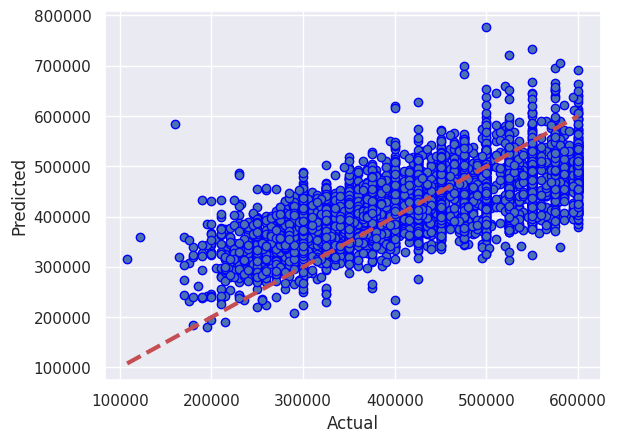

In [93]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [94]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
6 ==> 6
{'model__tol': 1e-05, 'model__solver': 'svd', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 0.1}
12 ==> 12
{'model__tol': 0.01, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1e-05}
18 ==> 18
{'model__tol': 1e-05, 'model__solver': 'lbfgs', 'model__random_state': 101, 'model__positive': True, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 0.1}
24 ==> 24
{'model__tol': 0.01, 'model__solver': 'lbfgs', 'model__random_state': 101, 'model__positive': True, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1}
-1 ==> -1
{'model__tol': 0.01, 'model__solver': 'lbfgs', 'model__random_state': 101, 'model__positive': True, 'model__max_iter': 100, 'model__fit_intercept': T

In [95]:
cv_results_df_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/False/0.01,1,0.444667,0.164287,0.002458,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,1e-05/sag/101/False/10000/True/True/0.01,2,0.444664,0.371956,0.002369,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
2,0.01/auto/101/False/1000000/True/False/10,3,0.444664,0.017139,0.003616,"{'model__tol': 0.01, 'model__solver': 'auto', ..."
3,1e-05/auto/101/False/100/True/False/1,4,0.444663,0.012164,0.001562,"{'model__tol': 1e-05, 'model__solver': 'auto',..."
4,0.001/auto/101/False/100000/True/False/1,4,0.444663,0.011346,0.001832,"{'model__tol': 0.001, 'model__solver': 'auto',..."
5,1e-05/lsqr/101/False/100000/True/False/10,6,0.444663,0.023682,0.004067,"{'model__tol': 1e-05, 'model__solver': 'lsqr',..."
6,1e-05/svd/101/False/100000/True/True/0.1,7,0.444663,0.024945,0.002769,"{'model__tol': 1e-05, 'model__solver': 'svd', ..."
7,0.001/cholesky/101/False/100/True/True/0.01,8,0.444663,0.017791,0.003564,"{'model__tol': 0.001, 'model__solver': 'choles..."
8,1e-05/svd/101/False/100000/True/True/0.01,9,0.444663,0.026362,0.002153,"{'model__tol': 1e-05, 'model__solver': 'svd', ..."
9,1e-05/sparse_cg/101/False/100000/True/True/0.01,10,0.444663,0.022387,0.001901,"{'model__tol': 1e-05, 'model__solver': 'sparse..."


In [96]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [97]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__tol': 0.001,
 'model__solver': 'sag',
 'model__random_state': 101,
 'model__positive': False,
 'model__max_iter': 100,
 'model__fit_intercept': True,
 'model__copy_X': False,
 'model__alpha': 0.01}

In [98]:
best_models if not_catboost else ''

{0: {'alpha': 0.01,
  'copy_X': False,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'sag',
  'tol': 0.001},
 6: {'alpha': 0.1,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100000,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'svd',
  'tol': 1e-05},
 12: {'alpha': 1e-05,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'sag',
  'tol': 0.01},
 18: {'alpha': 0.1,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': True,
  'random_state': 101,
  'solver': 'lbfgs',
  'tol': 1e-05},
 24: {'alpha': 1,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': True,
  'random_state': 101,
  'solver': 'lbfgs',
  'tol': 0.01},
 -1: {'alpha': 1,
  'copy_X': True,
  'fit

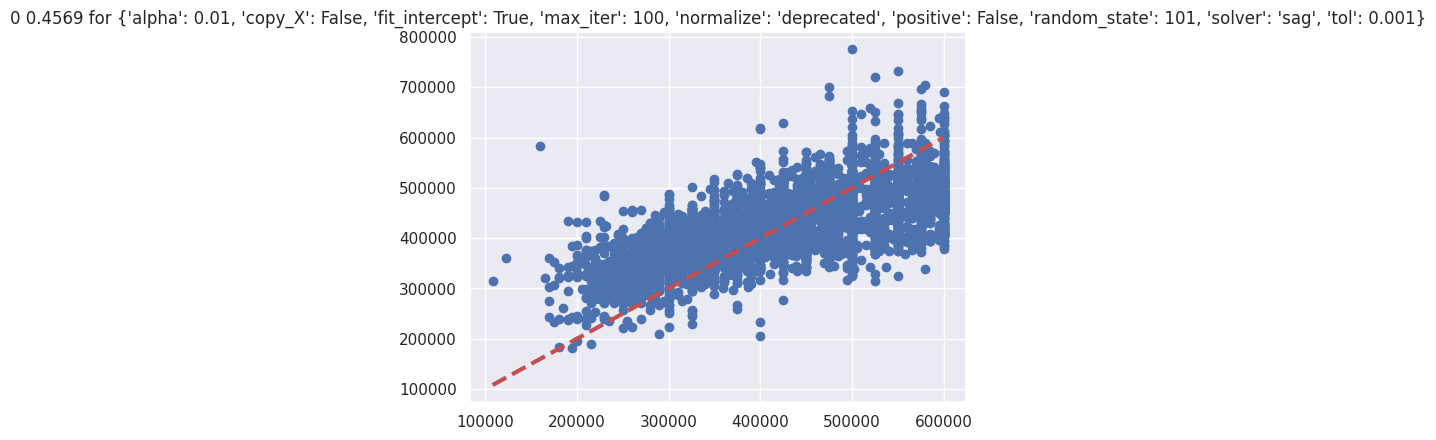

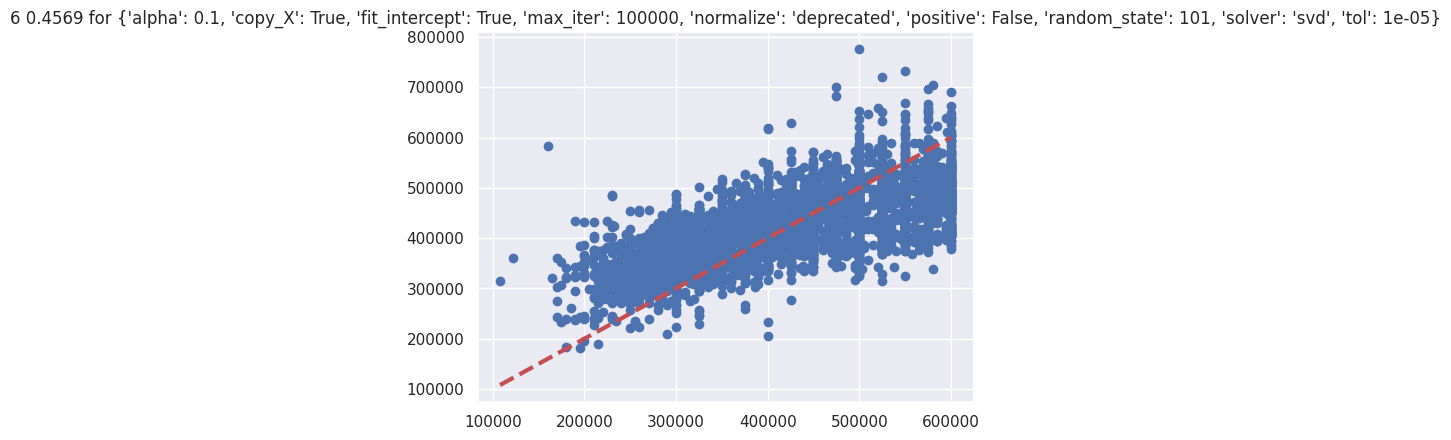

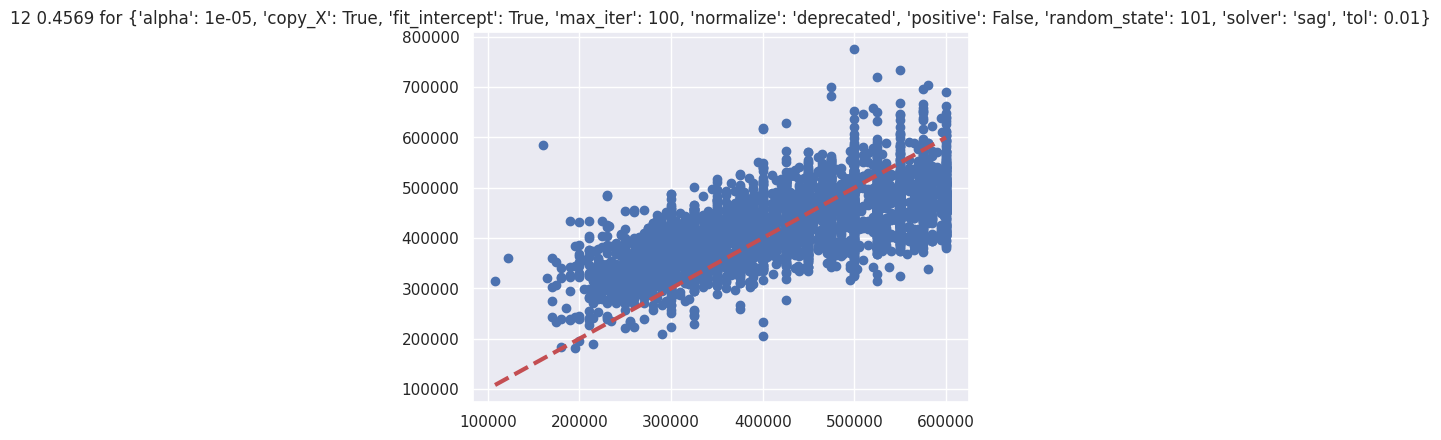

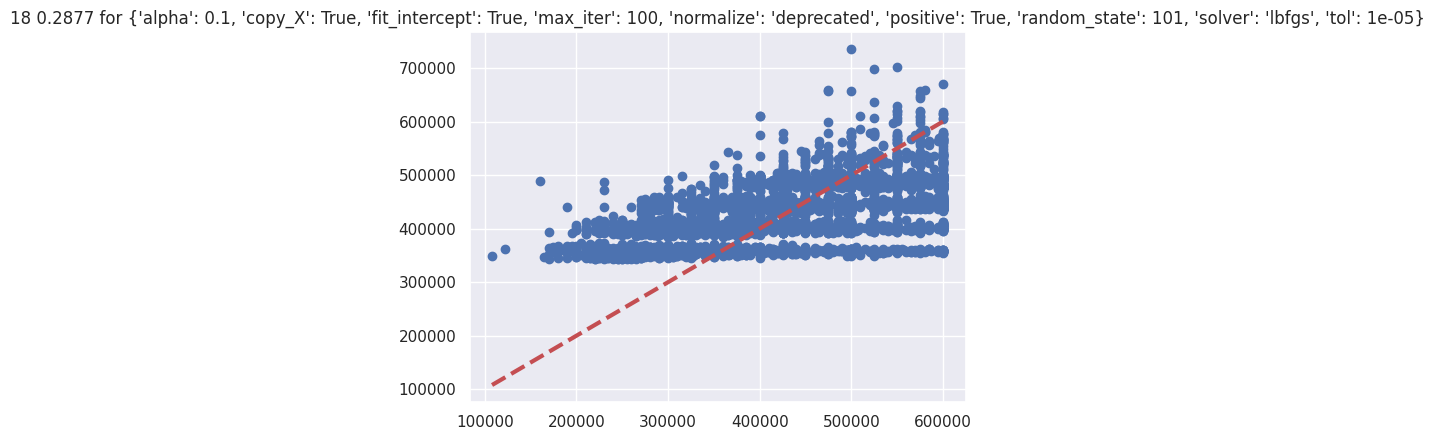

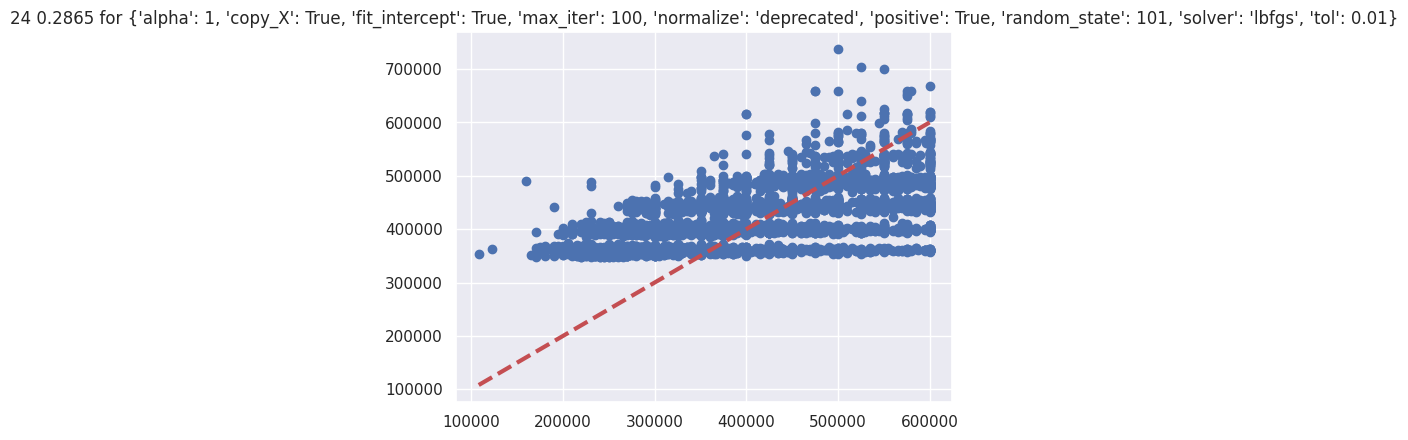

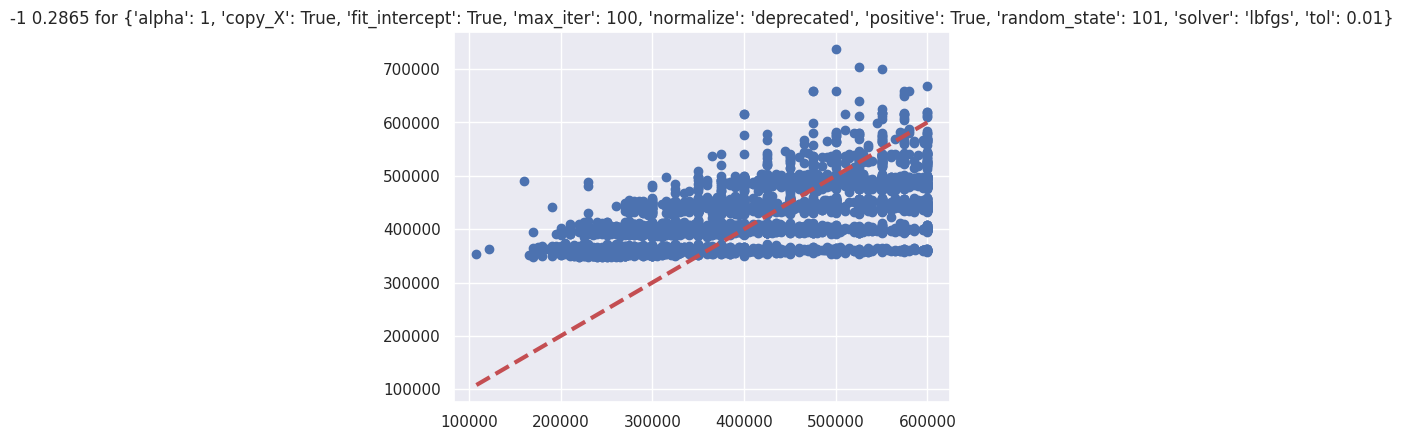

In [99]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

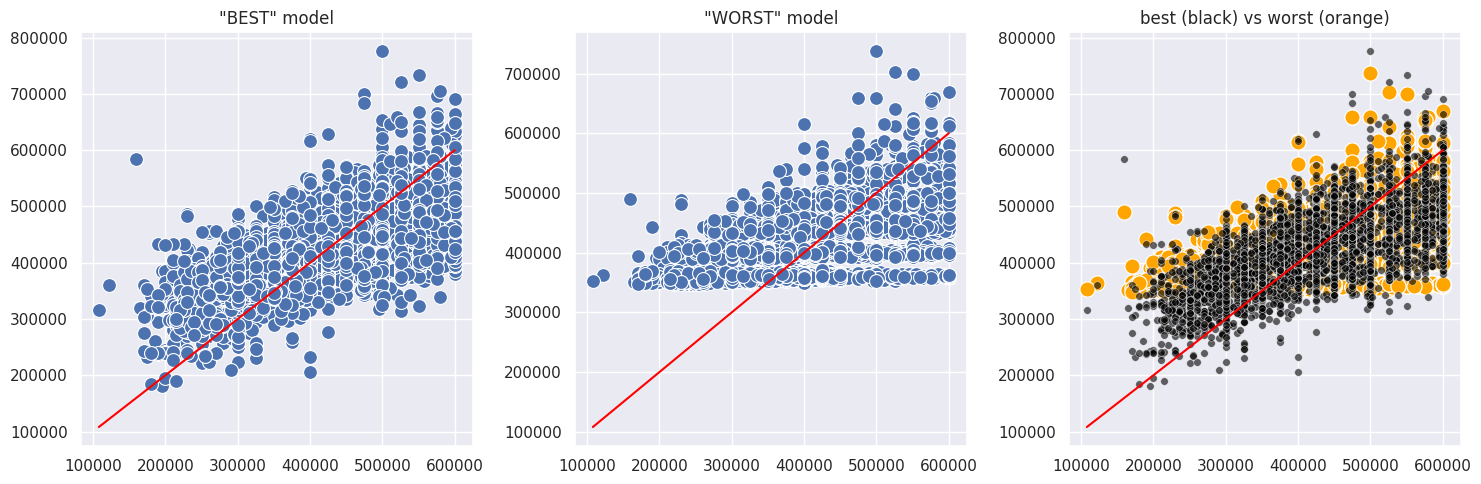

In [100]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [101]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

0.16428740819295248

In [102]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    old_best_score = old_results_json[key]['best score']
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

linear regression (ridge) (v06)


In [103]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=0.01, copy_X=False, max_iter=100, random_state=101,
                       solver='sag'))])

In [104]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score}")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)

# 0.45687994672121157 jh

pickled new version of model
0.45690009940574006 is new best score (it's better than 0.45689955499425794


In [105]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping


In [106]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping
